<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/multimodel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multiple Model Option

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git
# Change directory into cloned repo
%cd MADSmilestone2

In [22]:
# !git pull

In [ ]:
!pip install boto3

In [38]:
#!ls

In [6]:
# General Libraries
import pandas as pd
import numpy as np
import ast
# Custom Libraries
import Loading.load_data as ld

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
# import torchmetrics
# from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
from botocore.exceptions import ClientError
from torch.nn.modules.activation import ReLU
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
from torch.utils.data import Dataset, DataLoader
# import from module later
class ResizedClocks(Dataset):
    #Resized clock drawing dataset

    def __init__(self, round, round_labels):
        
       # Args:
           # round (int): Round to grab images from. 
           # values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
    
    def __len__(self):
        return len(self.vals)

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = self.vals[idx][1]
        bucket = "clockimages" #"test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif" #f"{self.round}_{spid}.tif"
        #filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
          client.download_file(bucket, obj_name, temp.name)

          im = Image.open(temp.name)

          gray = im.convert('1')
          resized = gray.resize((160, 207)) 
          im_arr = np.array(resized).astype(int)

          sample = {'image': im_arr, 'label': label}
        
          temp.close()

          return sample
          
        except botocore.exceptions.ClientError as e:
          #logging.error(e)
          pass

In [9]:
file = open("Data/Dictionaries/score_dicts/tr_scor_dict_bal.txt", "r")

contents = file.read()
im_scores = ast.literal_eval(contents)

In [10]:
batch_size = 8
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}

In [11]:
path = "/content/gdrive/MyDrive/numpy_files/Score_data/"
training_data, y_train_tensor = ld.load_np_files(path+"train_score_im.npy", path+"train_score_labels.npy")

(23621, 1, 368, 284)


In [12]:
validation_data, y_val_tensor = ld.load_np_files(path+"val_score_im.npy", path+"val_score_labels.npy")
test_data, y_test_tensor = ld.load_np_files(path+"tst_score_im.npy", path+"tst_score_labels.npy")

(2544, 1, 368, 284)
(2541, 1, 368, 284)


In [13]:
y_train_tensor = y_train_tensor.to(torch.long)
y_test_tensor = y_test_tensor.to(torch.long)
y_test_tensor = y_test_tensor.to(torch.long)

In [14]:
y_train_tensor.dtype

torch.int64

In [40]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)
#Labels 
#classes = (0.0, 1.0, 2.0, 3.0, 4.0, 5.0)
classes = (0, 1, 2, 3, 4, 5)

In [16]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64)
    self.bn2 = nn.BatchNorm2d(64) 

    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128)
    self.bn3 = nn.BatchNorm2d(128)
    
    # Fully connected layer
    self.fc1 = nn.Linear(128*46*35,6)
    #self.fc2 = nn.Linear(120, 60)
    #self.fc3 = nn.Linear(60, 30)
    #self.fc4 = nn.Linear(30, 3) # left with 3 for the three classes 

  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = x.view(x.size(0),128*46*35)
    x = self.fc1(x)


    return x 

In [17]:
def accuracy(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  
  #y_preds = y_pred.argmax(dim=1)

  correct_pred = (y_pred_prob == y_test).float()
  #print("correct sum: ", correct_pred.sum())
  #print('correct total length: ', len(correct_pred))
  #print(correct_pred)
  acc = correct_pred.sum() / len(correct_pred)
  
  #acc = correct_pred.sum().float() / float( y_test.size(0) )

  acc = torch.round(acc * 100)

  return acc

In [18]:
# Create model object 
model = ConvNet()
if torch.cuda.is_available():
    model = model.to(torch.double).cuda()
    print('Model training on GPU')
else:
    print("CUDA is not available. Training on CPU...")

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) #or ADAM/ momentum

print(model) 

Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [19]:
def train_val_model(epochs):
  for epoch in range(1, epochs + 1):

    # TRAINING ********************************
    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode (recommended)
    model.train()

    # Double check
    tr_run_loss=0
    tr_correct=0
    tr_total=0
    train_accu = []
    train_losses = []
    
    print('\nEpoch$ : %d'%epoch)
    for x_train_batch, y_train_batch in tqdm(train_loader):
        x_train_batch = x_train_batch.to(torch.double).to(device) # for GPU support
        y_train_batch = y_train_batch.to(torch.long).to(device) 

        #print(x_train_batch.shape)

        # sets gradients to 0 to prevent interference with previous epoch
        optimizer.zero_grad()

        # Forward pass through NN
        y_train_pred = model(x_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = accuracy(y_train_pred, y_train_batch)

        # Backward pass, updating weights
        train_loss.backward()
        optimizer.step()

        # Statistics
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

        # Double check scores
        tr_run_loss += train_loss.item()
        
        _, predicted = y_train_pred.max(1)
        tr_total += y_train_batch.size(0)
        tr_correct += predicted.eq(y_train_batch).sum().item()
       
    tr_loss = tr_run_loss/len(train_loader)
    accu = 100.*tr_correct/tr_total
   
    train_accu.append(accu)
    train_losses.append(tr_loss)
    print('Train Loss: %.3f | Train Accuracy: %.3f'%(tr_loss,accu))
    # VALIDATION****************************************   
    
    with torch.set_grad_enabled(False):
        val_epoch_loss = 0
        val_epoch_acc = 0

        # Double check
        val_run_loss=0
        val_correct=0
        val_total=0
        val_accu = []
        val_losses = []


        model.eval()
        for x_val_batch, y_val_batch in tqdm(validate_loader):
      
            x_val_batch =  x_val_batch.to(torch.double).to(device)
            y_val_batch = y_val_batch.to(torch.long).to(device)
                
            # Forward pass
            y_val_pred = model(x_val_batch)   
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = accuracy(y_val_pred, y_val_batch)
                
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

            # Double check
            
            val_run_loss += val_loss.item()
        
            _, predictedv = y_val_pred.max(1)
            val_total += y_train_batch.size(0)
            val_correct += predictedv.eq(y_val_batch).sum().item()
        
        vl_loss = val_run_loss/len(validate_loader)
        accuv = 100.*val_correct/val_total
    
        val_accu.append(accuv)
        val_losses.append(vl_loss)
        print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(vl_loss,accuv))


    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | \
    Val Loss: {val_epoch_loss/len(validate_loader):.5f}')

    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | \
    Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

In [20]:
train_val_model(20)


Epoch$ : 1


  0%|          | 0/2953 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 2953/2953 [04:05<00:00, 12.00it/s]


Train Loss: 2.742 | Train Accuracy: 30.574


100%|██████████| 318/318 [00:05<00:00, 54.78it/s]


Validation Loss: 1.571 | Validation Accuracy: 48.679
Epoch 001: Train Loss: 2.74188 |     Val Loss: 1.57131
Train Acc: 30.576 |     Val Acc: 30.434

Epoch$ : 2


100%|██████████| 2953/2953 [04:05<00:00, 12.01it/s]


Train Loss: 1.400 | Train Accuracy: 44.884


100%|██████████| 318/318 [00:05<00:00, 54.75it/s]


Validation Loss: 1.764 | Validation Accuracy: 44.025
Epoch 002: Train Loss: 1.40024 |     Val Loss: 1.76421
Train Acc: 44.903 |     Val Acc: 27.525

Epoch$ : 3


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 1.205 | Train Accuracy: 53.461


100%|██████████| 318/318 [00:05<00:00, 54.23it/s]


Validation Loss: 1.606 | Validation Accuracy: 56.604
Epoch 003: Train Loss: 1.20539 |     Val Loss: 1.60610
Train Acc: 53.438 |     Val Acc: 35.387

Epoch$ : 4


100%|██████████| 2953/2953 [04:06<00:00, 11.96it/s]


Train Loss: 1.093 | Train Accuracy: 58.490


100%|██████████| 318/318 [00:05<00:00, 54.38it/s]


Validation Loss: 1.707 | Validation Accuracy: 48.616
Epoch 004: Train Loss: 1.09254 |     Val Loss: 1.70699
Train Acc: 58.453 |     Val Acc: 30.393

Epoch$ : 5


100%|██████████| 2953/2953 [04:06<00:00, 11.96it/s]


Train Loss: 1.001 | Train Accuracy: 62.254


100%|██████████| 318/318 [00:05<00:00, 53.96it/s]


Validation Loss: 1.630 | Validation Accuracy: 54.717
Epoch 005: Train Loss: 1.00147 |     Val Loss: 1.63043
Train Acc: 62.207 |     Val Acc: 34.220

Epoch$ : 6


100%|██████████| 2953/2953 [04:06<00:00, 11.96it/s]


Train Loss: 0.929 | Train Accuracy: 65.222


100%|██████████| 318/318 [00:05<00:00, 54.33it/s]


Validation Loss: 1.764 | Validation Accuracy: 56.855
Epoch 006: Train Loss: 0.92923 |     Val Loss: 1.76411
Train Acc: 65.200 |     Val Acc: 35.572

Epoch$ : 7


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.864 | Train Accuracy: 67.575


100%|██████████| 318/318 [00:05<00:00, 54.41it/s]


Validation Loss: 1.858 | Validation Accuracy: 52.893
Epoch 007: Train Loss: 0.86430 |     Val Loss: 1.85849
Train Acc: 67.561 |     Val Acc: 33.072

Epoch$ : 8


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.803 | Train Accuracy: 70.133


100%|██████████| 318/318 [00:05<00:00, 54.59it/s]


Validation Loss: 2.540 | Validation Accuracy: 37.673
Epoch 008: Train Loss: 0.80308 |     Val Loss: 2.53988
Train Acc: 70.130 |     Val Acc: 23.472

Epoch$ : 9


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.747 | Train Accuracy: 72.309


100%|██████████| 318/318 [00:05<00:00, 54.45it/s]


Validation Loss: 3.106 | Validation Accuracy: 35.094
Epoch 009: Train Loss: 0.74675 |     Val Loss: 3.10642
Train Acc: 72.332 |     Val Acc: 21.868

Epoch$ : 10


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.696 | Train Accuracy: 74.150


100%|██████████| 318/318 [00:05<00:00, 54.42it/s]


Validation Loss: 1.974 | Validation Accuracy: 59.245
Epoch 010: Train Loss: 0.69623 |     Val Loss: 1.97402
Train Acc: 74.186 |     Val Acc: 37.072

Epoch$ : 11


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.645 | Train Accuracy: 76.013


100%|██████████| 318/318 [00:05<00:00, 54.54it/s]


Validation Loss: 2.199 | Validation Accuracy: 56.415
Epoch 011: Train Loss: 0.64468 |     Val Loss: 2.19897
Train Acc: 76.062 |     Val Acc: 35.324

Epoch$ : 12


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.598 | Train Accuracy: 78.142


100%|██████████| 318/318 [00:05<00:00, 54.45it/s]


Validation Loss: 2.751 | Validation Accuracy: 54.780
Epoch 012: Train Loss: 0.59785 |     Val Loss: 2.75139
Train Acc: 78.215 |     Val Acc: 34.261

Epoch$ : 13


100%|██████████| 2953/2953 [04:06<00:00, 11.98it/s]


Train Loss: 0.552 | Train Accuracy: 79.603


100%|██████████| 318/318 [00:05<00:00, 54.59it/s]


Validation Loss: 3.197 | Validation Accuracy: 54.277
Epoch 013: Train Loss: 0.55161 |     Val Loss: 3.19660
Train Acc: 79.701 |     Val Acc: 33.991

Epoch$ : 14


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.508 | Train Accuracy: 81.461


100%|██████████| 318/318 [00:05<00:00, 54.62it/s]


Validation Loss: 2.835 | Validation Accuracy: 54.465
Epoch 014: Train Loss: 0.50795 |     Val Loss: 2.83494
Train Acc: 81.574 |     Val Acc: 34.072

Epoch$ : 15


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.469 | Train Accuracy: 82.926


100%|██████████| 318/318 [00:05<00:00, 54.52it/s]


Validation Loss: 8.721 | Validation Accuracy: 29.308
Epoch 015: Train Loss: 0.46865 |     Val Loss: 8.72060
Train Acc: 83.056 |     Val Acc: 18.192

Epoch$ : 16


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.429 | Train Accuracy: 84.196


100%|██████████| 318/318 [00:05<00:00, 54.64it/s]


Validation Loss: 3.575 | Validation Accuracy: 43.145
Epoch 016: Train Loss: 0.42897 |     Val Loss: 3.57491
Train Acc: 84.351 |     Val Acc: 26.981

Epoch$ : 17


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.397 | Train Accuracy: 85.606


100%|██████████| 318/318 [00:05<00:00, 54.50it/s]


Validation Loss: 8.745 | Validation Accuracy: 18.050
Epoch 017: Train Loss: 0.39688 |     Val Loss: 8.74463
Train Acc: 85.756 |     Val Acc: 11.116

Epoch$ : 18


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.362 | Train Accuracy: 86.914


100%|██████████| 318/318 [00:05<00:00, 54.50it/s]


Validation Loss: 3.592 | Validation Accuracy: 52.830
Epoch 018: Train Loss: 0.36188 |     Val Loss: 3.59235
Train Acc: 87.077 |     Val Acc: 33.060

Epoch$ : 19


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.337 | Train Accuracy: 88.205


100%|██████████| 318/318 [00:05<00:00, 54.47it/s]


Validation Loss: 3.290 | Validation Accuracy: 49.308
Epoch 019: Train Loss: 0.33729 |     Val Loss: 3.28953
Train Acc: 88.370 |     Val Acc: 30.843

Epoch$ : 20


100%|██████████| 2953/2953 [04:06<00:00, 11.99it/s]


Train Loss: 0.310 | Train Accuracy: 88.781


100%|██████████| 318/318 [00:05<00:00, 54.57it/s]

Validation Loss: 7.518 | Validation Accuracy: 22.642
Epoch 020: Train Loss: 0.31001 |     Val Loss: 7.51788
Train Acc: 88.949 |     Val Acc: 13.984


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

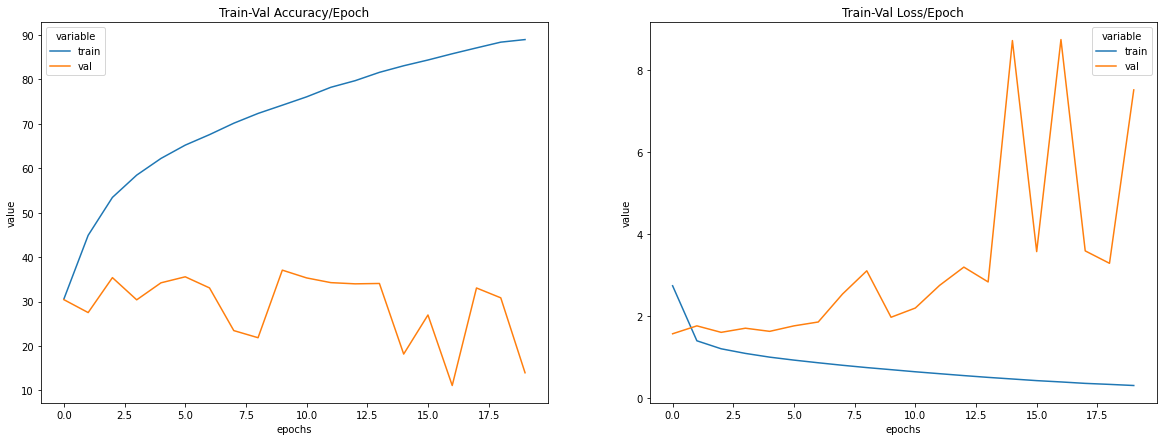

In [21]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc.csv', index = False)
# train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss.csv', index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [41]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in test_loader:
    x_test_batch = x_test_batch.to(torch.double).to(device)#.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

In [42]:
len(y_test)
len(all_preds)

2541

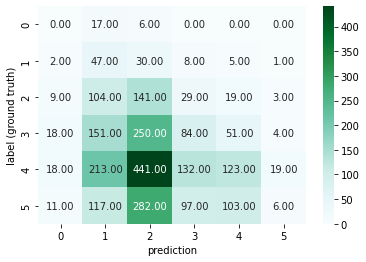

In [43]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_preds))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [44]:
def plot_conf_matrix(matrix, class_names, session):
  df_cm = pd.DataFrame(matrix, class_names, class_names) #matrix.numpy()
  df_cm.to_csv("/content/gdrive/MyDrive/Colab Notebooks/model_charts/conf_matrix_{}".format(session))
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
#all_pred = conf_matrix(model, train_loader)
#confmat = ConfusionMatrix(num_classes = 3)
#cmtx = confmat(y_train_tensor.cpu().numpy(), all_preds)
#cmtx = confmat(y_test, all_pred)
class_names = ["not recognized", "really bad", "bad", "ok", "good", "great"]
class_vals = [0,1,2,3,4,5]
#plot_conf_matrix(cmtx, class_names, 2)
print(classification_report(y_test, all_preds, class_vals))
#print(classification_report(y_train_tensor.numpy(), all_preds, class_vals))
#print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.07      0.51      0.13        93
           2       0.12      0.46      0.19       305
           3       0.24      0.15      0.19       558
           4       0.41      0.13      0.20       946
           5       0.18      0.01      0.02       616

    accuracy                           0.16      2541
   macro avg       0.17      0.21      0.12      2541
weighted avg       0.27      0.16      0.15      2541



In [46]:
test_dict_preds = all_preds.cpu().numpy()

In [48]:
# np.savetxt("/content/gdrive/MyDrive/y_preds_firstrun.csv", test_dict_preds)